In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
from ROOT import TFile, TTree, TH1F, TH2F, TChain, TCanvas, kRed, kBlue, gStyle, gROOT, gPad
#from ROOT import gROOT, TCanvas, TF1, TFile, TTree, gRandom, TH1F
from utils import rootnotes
from utils import rootprint
import numpy as np
import os
import csv, sys

Welcome to ROOTaaS 6.06/02


In [2]:
ttFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/t~t~/test2/combined.root")
ttTree = ttFile.Get("event")
jjFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/jj/combined.root")
jjTree = jjFile.Get("event")

In [ ]:
%%rootprint

ttTree.Print()

In [3]:
def WriteTopInfo(RootFile, CsvFile) : 
    processFile = TFile(RootFile)
    tree = processFile.Get("event")
    with open(CsvFile, "w") as f:
        writer = csv.writer(f, delimiter=',')
        # write header
        writer.writerow(["pT","m","zMu","tau32","xMu","dRbMu","weight"])
        for event in tree:
            if event.Top_Pt.size() <1 :
                continue
            data = [event.Top_Pt[0], event.Top_Mass[0], event.Top_zMu[0], event.Top_Tau32[0], 
                    event.Top_xMu[0], event.Top_DeltaR_bMu[0], event.cWeight]
            writer.writerow(data)

WriteTopInfo("/Users/prerit/Physics/100TeV/Stops/Results/t~t~/test2/combined.root","/Users/prerit/Physics/100TeV/Stops/analysis/bin/TopTag/tops.csv")
WriteTopInfo("/Users/prerit/Physics/100TeV/Stops/Results/jj/combined.root","/Users/prerit/Physics/100TeV/Stops/analysis/bin/TopTag/jets.csv")

## Top-tagging for hadronic top decays
* We use $\tau_3/\tau_2$ (N-subjettiness)  and a top-mass window
* We consider jets with $p_T > 2$ TeV for estimatimg tagging efficiency 

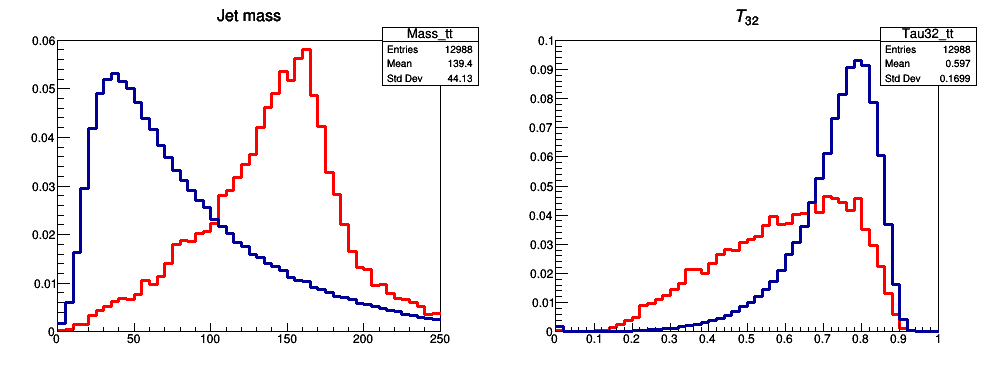

Info in <TCanvas::Print>: png file /var/folders/_r/z89y9x9j7cv8h_9n9l58gd8c0000gn/T/tmpIkdYMU.png has been created


In [4]:
c=rootnotes.canvas(size=(1000,400))
c.Divide(2,1)

#Plot top mass 
c.cd(1)
h_Mass = {}
h_Mass["tt"]   = TH1F("Mass_tt", "Jet mass", 50, 0 ,250)
h_Mass["jj"]   = TH1F("Mass_jj", "Jet mass", 50, 0 ,250)
ttTree.Draw("Top_Mass[0] >>+Mass_tt","cWeight*(Top_Mass[0]>0. && Top_Pt[0]>2000. && @IsoMu_Pt.size() == 0) && Top_DeltaR_bMu[0]<0.","hist") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Mass["tt"].Draw("hist")
jjTree.Draw("Top_Mass[0] >>+Mass_jj","cWeight*(Top_Mass[0]>0. && Top_Pt[0]>2000. && @IsoMu_Pt.size() == 0) && Top_DeltaR_bMu[0]<0.","histsame") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Mass["jj"].Draw("hist same")
h_Mass["tt"].Scale(1/h_Mass["tt"].Integral())
h_Mass["jj"].Scale(1/h_Mass["jj"].Integral())
h_Mass["tt"].SetLineColor(kRed)
h_Mass["tt"].SetMaximum(0.06)
h_Mass["tt"].SetMinimum(0.00)

#Plot tau32 
c.cd(2)
h_Tau32 = {}
h_Tau32["tt"]   = TH1F("Tau32_tt", "\Tau_{32}", 50, 0. ,1)
h_Tau32["jj"]   = TH1F("Tau32_jj", "\tau_{32}", 50, 0. ,1)
ttTree.Draw("Top_Tau32[0] >>+Tau32_tt","cWeight*(Top_Tau32[0]>0. && Top_Mass[0]>0. && Top_Pt[0]>2000. && @IsoMu_Pt.size() == 0) && Top_DeltaR_bMu[0]<0.","hist") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Tau32["tt"].Draw("hist")
jjTree.Draw("Top_Tau32[0] >>+Tau32_jj","cWeight*(Top_Tau32[0]>0. && Top_Mass[0]>0. && Top_Pt[0]>2000. && @IsoMu_Pt.size() == 0) && Top_DeltaR_bMu[0]<0.","histsame") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Tau32["jj"].Draw("hist same")
h_Tau32["tt"].Scale(1/h_Tau32["tt"].Integral())
h_Tau32["jj"].Scale(1/h_Tau32["jj"].Integral())
h_Tau32["tt"].SetLineColor(kRed)
h_Tau32["tt"].SetMaximum(0.1)
h_Tau32["tt"].SetMinimum(0.0)

c

In [ ]:
tau32_cutoffs = np.arange(.35,.65,.01)
mass_low_cutoffs = np.arange(90,140,5)
mass_high_cutoffs = np.arange(180,230,5)
topsFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/t~t~/test2/combined.root")
topsTree = topsFile.Get("event")
jetsFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/jj/combined.root")
jetsTree = jetsFile.Get("event")

# calculate true positive rate
print("Calculating true positive rate for top-tagging")
sys.stdout.flush()
iEvent = 0
total=0.
nParams = len(tau32_cutoffs)*len(mass_low_cutoffs)*len(mass_high_cutoffs)
topTags = np.zeros(nParams)
para_tau32 = np.zeros(nParams)
para_mass_low = np.zeros(nParams)
para_mass_high = np.zeros(nParams)
for event in topsTree :
    if event.Top_Pt.size() <1 :
        continue
    if event.Top_zMu[0] > 0. or event.Top_Pt[0] < 2000. :
        continue
    tau32 = event.Top_Tau32[0]
    mass = event.Top_Mass[0]
    weight = event.cWeight
    total=total+weight
    iEvent=iEvent+1
    j=0
    for tau32_cutoff in tau32_cutoffs :
        for mass_low_cutoff in mass_low_cutoffs :
            for mass_high_cutoff in mass_high_cutoffs :
                if tau32>0.1 and tau32<tau32_cutoff and mass > mass_low_cutoff and mass < mass_high_cutoff:
                    topTags[j]=topTags[j]+weight
                para_mass_low[j] = mass_low_cutoff
                para_mass_high[j] = mass_high_cutoff
                para_tau32[j] = tau32_cutoff
                j=j+1
    if iEvent%5000 == 0 :
        print("    Finished "+str(iEvent)+" events")
        sys.stdout.flush()
tpr = topTags/total

# calculate false positive rate
print("Calculating false positive rate for top-tagging")
sys.stdout.flush()
iEvent = 0
total=0.
nParams = len(tau32_cutoffs)*len(mass_low_cutoffs)*len(mass_high_cutoffs)
topTags = np.zeros(nParams)
for event in jetsTree :
    if event.Top_Pt.size() <1 :
        continue
    if event.Top_zMu[0] > 0. or event.Top_Pt[0] < 2000. :
        continue
    tau32 = event.Top_Tau32[0]
    mass = event.Top_Mass[0]
    weight = event.cWeight
    total=total+weight
    iEvent=iEvent+1
    j=0
    for tau32_cutoff in tau32_cutoffs :
        for mass_low_cutoff in mass_low_cutoffs :
            for mass_high_cutoff in mass_high_cutoffs :
                if tau32>0.1 and tau32<tau32_cutoff and mass > mass_low_cutoff and mass < mass_high_cutoff:
                    topTags[j]=topTags[j]+weight
                j=j+1
    if iEvent%5000 == 0 :
        print("    Finished "+str(iEvent)+" events")
        sys.stdout.flush()
fpr = topTags/total
        

Calculating true positive rate for top-tagging
    Finished 5000 events
    Finished 10000 events


In [ ]:
plt.rc('text', usetex=True)
plt.figure(1)
plt.figure(figsize=(20,8))

# Choice of cutoffs 
Cond = np.logical_and(abs(para_mass_low - 125.)<2.5, abs(para_tau32 - 0.49)<.005)
Cond = np.logical_and(Cond, abs(para_mass_high-190.) < 2.5)
fpr0 = fpr[Cond]
tpr0 = tpr[Cond]

# Plot ROC curve with colormap of top mass (lower limit)
plt.subplot(131)
plt.scatter(fpr,tpr,c=para_mass_low, s=50, lw=0, cmap='inferno')
plt.plot(fpr[Cond], tpr[Cond],'xb',mew=6,ms=15)
plt.axhline(tpr0, ls='dashed', c='b',lw=3)
plt.axvline(fpr0, ls='dashed', c='b',lw=3)
plt.xlabel('QCD mistag rate', fontsize=20)
plt.ylabel('Top tag efficiency', fontsize=20)
plt.colorbar()
plt.axis([0,.1,0.1,.5])
plt.grid(True)
plt.title(r"$m_{top}$ (lower)", fontsize=25)

# Plot ROC curve with colormap of N-subjettiness
plt.subplot(132)
plt.scatter(fpr,tpr,c=para_tau32, s=50, lw=0, cmap='inferno')
plt.plot(fpr[Cond], tpr[Cond],'xb',mew=6,ms=15)
plt.axhline(tpr0, ls='dashed', c='b',lw=3)
plt.axvline(fpr0, ls='dashed', c='b',lw=3)
plt.xlabel('QCD mistag rate', fontsize=20)
plt.ylabel('Top tag efficiency', fontsize=20)
plt.colorbar()
plt.axis([0,.1,0.1,.5])
plt.grid(True)
plt.title(r"$\tau_3/\tau_2$", fontsize=25)

# Plot ROC curve with colormap of top mass (upper limit)
plt.subplot(133)
plt.scatter(fpr,tpr,c=para_mass_high, s=50, lw=0, cmap='inferno_r')
plt.plot(fpr[Cond], tpr[Cond],'xb',mew=6,ms=15)
plt.axhline(tpr0, ls='dashed', c='b',lw=3)
plt.axvline(fpr0, ls='dashed', c='b',lw=3)
plt.xlabel('QCD mistag rate', fontsize=20)
plt.ylabel('Top tag efficiency', fontsize=20)
plt.colorbar()
plt.axis([0,.1,0.1,.5])
plt.grid(True)
plt.title(r"$m_{top}$ (upper)", fontsize=25)

plt.show()

## Top-tagging for leptonic top decays
* We use $x_\mu = 1 - \frac{m_b^2}{m_{b \mu}^2}$  and $\Delta R_{b \mu} \frac{p_T^{jet}}{2 m_{top}}$
* We consider jets with $p_T > 800$ GeV for estimatimg tagging efficiency 

In [ ]:
c=rootnotes.canvas(size=(1000,400))
c.Divide(3,1)

#Plot x_mu 
c.cd(1)
h_xMu = {}
h_xMu["tt"]   = TH1F("xMu_tt", "x_{\mu}", 50, 0 ,1)
h_xMu["jj"]   = TH1F("xMu_jj", "x_{\mu}", 50, 0 ,1)
ttTree.Draw("Top_xMu[0] >>+xMu_tt","cWeight*(Top_xMu[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0)","hist") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_xMu["tt"].Draw("hist")
jjTree.Draw("Top_xMu[0] >>+xMu_jj","cWeight*(Top_xMu[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0)","histsame") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_xMu["jj"].Draw("hist same")
h_xMu["tt"].Scale(1/h_xMu["tt"].Integral())
h_xMu["jj"].Scale(1/h_xMu["jj"].Integral())
h_xMu["tt"].SetLineColor(kRed)
h_xMu["tt"].SetMaximum(0.1)
h_xMu["tt"].SetMinimum(0.01)

#Plot dR(b,mu)
c.cd(2)
h_DeltaR_bMu = {}
h_DeltaR_bMu["tt"]   = TH1F("DeltaR_bMu_tt", "\Delta R_{b \mu} * p_T / (350 GeV)", 50, 0 ,1)
h_DeltaR_bMu["jj"]   = TH1F("DeltaR_bMu_jj", "\Delta R_{b \mu} * p_T / (350 GeV)", 50, 0 ,1)
ttTree.Draw("Top_DeltaR_bMu[0]*Top_Pt[0]/350. >>+DeltaR_bMu_tt","cWeight*(Top_DeltaR_bMu[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0)","hist") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_DeltaR_bMu["tt"].Draw("hist")
jjTree.Draw("Top_DeltaR_bMu[0]*Top_Pt[0]/350. >>+DeltaR_bMu_jj","cWeight*(Top_DeltaR_bMu[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0)","histsame") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_DeltaR_bMu["jj"].Draw("hist same")
h_DeltaR_bMu["tt"].Scale(1/h_DeltaR_bMu["tt"].Integral())
h_DeltaR_bMu["jj"].Scale(1/h_DeltaR_bMu["jj"].Integral())
h_DeltaR_bMu["tt"].SetLineColor(kRed)
h_DeltaR_bMu["tt"].SetMaximum(0.22)
h_DeltaR_bMu["tt"].SetMinimum(0.01)

#Plot top mass 
c.cd(3)
h_Mass = {}
h_Mass["tt"]   = TH1F("Mass_tt", "Jet mass", 50, 0 ,250)
h_Mass["jj"]   = TH1F("Mass_jj", "Jet mass", 50, 0 ,250)
ttTree.Draw("Top_Mass[0] >>+Mass_tt","cWeight*(Top_zMu[0]>0. && Top_Mass[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0) ","hist") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Mass["tt"].Draw("hist")
jjTree.Draw("Top_Mass[0] >>+Mass_jj","cWeight*(Top_zMu[0]>0. && Top_Mass[0]>0. && Top_Pt[0]>800. && @IsoMu_Pt.size() == 0) ","histsame") # && Top_DeltaR_bMu[0]<800./Top_Pt[0]")
h_Mass["jj"].Draw("hist same")
h_Mass["tt"].Scale(1/h_Mass["tt"].Integral())
h_Mass["jj"].Scale(1/h_Mass["jj"].Integral())
h_Mass["tt"].SetLineColor(kRed)
h_Mass["tt"].SetMaximum(0.07)
h_Mass["tt"].SetMinimum(0.006)

c

In [ ]:
dRbMu_cutoffs = np.arange(.0,.5,.02)
mass_cutoffs = np.arange(20,200,10)
xMu_cutoffs = np.arange(0.5,0.9,0.02)
topsFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/t~t~/test2/combined.root")
topsTree = topsFile.Get("event")
jetsFile = TFile("/Users/prerit/Physics/100TeV/Stops/Results/jj/combined.root")
jetsTree = jetsFile.Get("event")

# calculate true positive rate
print("Calculating true positive rate for top-tagging")
sys.stdout.flush()
iEvent = 0
total=0.
nParams = len(dRbMu_cutoffs)*len(mass_cutoffs)*len(xMu_cutoffs)
topTags = np.zeros(nParams)
para_dRbMu = np.zeros(nParams)
para_mass = np.zeros(nParams)
para_xMu = np.zeros(nParams)
for event in topsTree :
    if event.Top_Pt.size() <1 :
        continue
    if event.Top_zMu[0] < 0. or event.Top_Pt[0] < 800. :
        continue
    dRbMu = event.Top_DeltaR_bMu[0]*event.Top_Pt[0]/350.
    mass = event.Top_Mass[0]
    xMu = event.Top_xMu[0]
    weight = event.cWeight
    total=total+weight
    iEvent=iEvent+1
    j=0
    for dRbMu_cutoff in dRbMu_cutoffs :
        for mass_cutoff in mass_cutoffs :
            for xMu_cutoff in xMu_cutoffs :
                if dRbMu>dRbMu_cutoff and mass > mass_cutoff and xMu > xMu_cutoff:
                    topTags[j]=topTags[j]+weight
                para_dRbMu[j] = dRbMu_cutoff
                para_mass[j] = mass_cutoff
                para_xMu[j] = xMu_cutoff
                j=j+1
    if iEvent%500 == 0 :
        print("    Finished "+str(iEvent)+" events")
        sys.stdout.flush()
tpr_lep = topTags/total

# calculate false positive rate
print("Calculating false positive rate for top-tagging")
sys.stdout.flush()
iEvent = 0
total=0.
nParams = len(dRbMu_cutoffs)*len(mass_cutoffs)*len(xMu_cutoffs)
topTags = np.zeros(nParams)
for event in jetsTree :
    if event.Top_Pt.size() <1 :
        continue
    if event.Top_zMu[0] < 0. or event.Top_Pt[0] < 800. :
        continue
    dRbMu = event.Top_DeltaR_bMu[0]*event.Top_Pt[0]/350.
    mass = event.Top_Mass[0]
    xMu = event.Top_xMu[0]
    weight = event.cWeight
    total=total+weight
    iEvent=iEvent+1
    j=0
    for dRbMu_cutoff in dRbMu_cutoffs :
        for mass_cutoff in mass_cutoffs :
            for xMu_cutoff in xMu_cutoffs :
                if dRbMu>dRbMu_cutoff and mass > mass_cutoff and xMu > xMu_cutoff:
                    topTags[j]=topTags[j]+weight
                j=j+1
    if iEvent%500 == 0 :
        print("    Finished "+str(iEvent)+" events")
        sys.stdout.flush()
fpr_lep = topTags/total
   

In [ ]:
plt.rc('text', usetex=True)
plt.figure(1)
plt.figure(figsize=(20,8))

# Choice of cutoffs 
Cond = np.logical_and(abs(para_xMu - 0.81)<.01, abs(para_dRbMu - 0.2)<.01)
Cond = np.logical_and(Cond, abs(para_mass-40) < 2.5)
fpr0 = fpr_lep[Cond]
tpr0 = tpr_lep[Cond]

# Plot ROC curve with colormap of x_mu 
plt.subplot(121)
plt.scatter(fpr_lep,tpr_lep,c=para_xMu, s=50, lw=0, cmap='Blues_r')
plt.plot(fpr_lep[Cond], tpr_lep[Cond],'xr',mew=6,ms=15)
plt.axhline(tpr0, ls='dashed', c='r')
plt.axvline(fpr0, ls='dashed', c='r')
plt.xlabel('QCD mistag rate', fontsize=20)
plt.ylabel('Top tag efficiency', fontsize=20)
plt.colorbar()
plt.axis([0,.1,0.2,.56])
plt.grid(True)
plt.title(r"$x_{\mu}$", fontsize=25)

# Plot ROC curve with colormap of DeltaR(b,muon)
plt.subplot(122)
plt.scatter(fpr_lep,tpr_lep,c=para_dRbMu, s=50, lw=0, cmap='Blues_r')
plt.plot(fpr_lep[Cond], tpr_lep[Cond],'xr',mew=6,ms=15)
plt.axhline(tpr0, ls='dashed', c='r')
plt.axvline(fpr0, ls='dashed', c='r')
plt.xlabel('QCD mistag rate', fontsize=20)
plt.ylabel('Top tag efficiency', fontsize=20)
plt.colorbar()
plt.axis([0,.1,0.2,.56])
plt.grid(True)
plt.title(r"$\Delta R_{b \mu} \times p_T^{jet}/(2 m_{top})$", fontsize=25)

plt.show()